<a href="https://colab.research.google.com/github/sverdoot/optimizer-SUG-torch/blob/master/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Optimization project")
os.getcwd()
import os

file_path = "./CIFAR10"
directory = os.path.dirname(file_path)

try:
    os.stat(directory)
except:
    os.mkdir(directory)       

In [0]:
import torch
from torch.optim import Optimizer
import math
import copy

class SUG(Optimizer):
    def __init__(self, params, l_0, d_0=0, prob=1., eps=1e-4, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):
        if l_0 < 0.0:
            raise ValueError("Invalid Lipsitz constant of gradient: {}".format(l_0))
        if d_0 < 0.0:
            raise ValueError("Invalid disperion of gradient: {}".format(d_0))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(L=l_0, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        self.Lips = l_0
        self.prev_Lips = l_0
        self.D_0 = d_0
        self.eps = eps
        self.prob = prob
        self.start_param = params
        self.upd_sq_grad_norm = None
        self.sq_grad_norm = None
        self.loss = torch.tensor(0.)
        self.closure = None
        super(SUG, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SUG, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    def comp_batch_size(self):
        """Returns optimal batch size for given d_0, eps and l_0;

        """
        return math.ceil(2 * self.D_0 * self.eps / self.prev_Lips)

    def step(self, loss, closure):
        """Performs a single optimization step.

        Arguments:
            loss : current loss

            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        self.start_params = []
        self.loss = loss
        self.sq_grad_norm = 0
        self.closure = closure
        for gr_idx, group in enumerate(self.param_groups):
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
            self.start_params.append([])
            for p_idx, p in enumerate(group['params']):
                self.start_params[gr_idx].append([p.data])
                if p.grad is None:
                    continue
                self.start_params[gr_idx][p_idx].append(p.grad.data)
                d_p = self.start_params[gr_idx][p_idx][1]
                p_ = self.start_params[gr_idx][p_idx][0]
                self.sq_grad_norm += torch.sum(p.grad.data * p.grad.data)
                
                if weight_decay != 0:
                   d_p.add_(weight_decay, p.data)
                
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.zeros_like(p.data)
                        buf.mul_(momentum).add_(d_p)
                    else:
                        buf = param_state['momentum_buffer']
                        buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf
                self.start_params[gr_idx][p_idx][1] = d_p
        i = 0
        difference = -1
        while difference < 0:
            self.Lips = max(self.prev_Lips * 2 ** (i - 1), 2.)
            for gr_idx, group in enumerate(self.param_groups):
                for p_idx, p in enumerate(group['params']):
                    if p.grad is None:
                        continue
                    start_param_val = self.start_params[gr_idx][p_idx][0]
                    start_param_grad = self.start_params[gr_idx][p_idx][1]
                    p.data = start_param_val - 1/(2*self.Lips) * start_param_grad
            difference, upd_loss = self.stop_criteria()
            i += 1
        self.prev_Lips = self.Lips

        return self.Lips, i

    def stop_criteria(self):
        """Checks if the Lipsitz constant of gradient is appropriate
        
           <g(x_k), w_k - x_k> + 2L_k / 2 ||x_k - w_k||^2 = - 1 / (2L_k)||g(x_k)||^2 + 1 / (4L_k)||g(x_k)||^2 = -1 / (4L_k)||g(x_k)||^2                
        """
        cur_loss = self.loss.item()
        upd_loss = self.closure().item()
        major =  cur_loss - 1 / (4 * self.Lips) * self.sq_grad_norm
        return major - upd_loss + self.eps / 10, upd_loss

    def get_lipsitz_const(self):
        """Returns current Lipsitz constant of the gradient of the loss function
        """
        return self.Lips
    
    def get_sq_grad(self):
        """Returns the current second norm of the gradient of the loss function 
           calculated by the formula
           
           ||f'(p_1,...,p_n)||_2^2 ~ \sum\limits_{i=1}^n ((df/dp_i)(p1,...,p_n))^2 
        """
        self.upd_sq_grad_norm = 0
        for gr_idx, group in enumerate(self.param_groups):
            for p_idx, p in enumerate(group['params']):
                if p.grad is None:
                    continue
                self.upd_sq_grad_norm += torch.sum(p.grad.data * p.grad.data) 
        
        return self.upd_sq_grad_norm

In [0]:
%matplotlib inline
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import time

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=0)

## Data

In [0]:
batch_size = 4

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

valid_dataset = torchvision.datasets.CIFAR10(root='/data', train=True, 
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [11]:
valid_size=0.15
num_train = len(trainset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))

np.random.seed(42)
np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(trainset, 
               batch_size=batch_size, sampler=train_sampler,
               num_workers=2)

validloader = torch.utils.data.DataLoader(valid_dataset, 
               batch_size=batch_size, sampler=valid_sampler,
               num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

170500096it [00:47, 4113251.36it/s]                               

In [0]:
batchs_per_epoch = len(trainloader) / batch_size

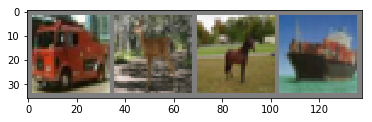

truck	 deer	horse	 ship


In [13]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(validloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('\t'.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Model

### simple CNN

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Train

In [0]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def model_step(model, optimizer, criterion, inputs, labels):
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    if model.training:
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
    if optimizer.__class__.__name__ != 'SUG':
        optimizer.step()
    else:
        def closure():
            optimizer.zero_grad()
            upd_outputs = model(inputs)
            upd_loss = criterion(upd_outputs, labels)
            upd_loss.backward()
            return upd_loss

        optimizer.step(loss, closure)

    return loss.item()

In [0]:
def train(model, trainloader, criterion, optimizer, n_epochs=2, validloader=None, eps=1e-5, print_every=1):
    tr_loss, val_loss, lips, times, grad, acc = ([] for i in range(6))
    start_time = time.time()
    model.to(device=device)
    for ep in range(n_epochs):
        model.train()
        i = 0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device=device), Variable(labels).to(device=device)

            tr_loss.append(model_step(model, optimizer, criterion, inputs, labels))
            if optimizer.__class__.__name__ == 'SUG':
                lips.append(optimizer.get_lipsitz_const())
                grad.append(optimizer.get_sq_grad)
        times.append(time_since(start_time))
        if ep % print_every == 0:
            print("Epoch {}, training loss {}, time passed {}".format(ep, sum(tr_loss[-i:]) / i, time_since(start_time)))

        if validloader is None:
            continue
        model.zero_grad()
        model.eval()
        j = 0
        for j, data in enumerate(validloader):
            inputs, labels = data
            inputs, labels = inputs.to(device=device), labels.to(device=device)
            val_loss.append(model_step(model, optimizer, criterion, inputs, labels))
        if ep % print_every == 0:
            print("Validation loss {}".format(sum(val_loss[-j:]) / j))
        
    return tr_loss, times, val_loss, lips, grad

In [0]:
def concat_states(state1, state2):
    states = {
            'epoch': state1['epoch'] + state2['epoch'],
            'state_dict': state2['state_dict'],
            'optimizer': state2['optimizer'],
            'tr_loss' : state1['tr_loss'] + state2['tr_loss'],
            'val_loss' : state1['val_loss'] + state2['val_loss'],
            'lips' : state1['lips'] + state2['lips'],
            'grad' : state1['grad'] + state2['grad'],
            'times' : state1['times'] + list(map(lambda x: x + state1['times'][-1],state2['times']))
             }
    return states

In [0]:
print_every = 4
n_epochs = 20
tr_loss = {}
tr_loss['sgd'] = {}
val_loss = {}
val_loss['sgd'] = {}
lrs = [0.01, 0.005]
criterion = nn.CrossEntropyLoss(reduction="mean")

In [34]:
for lr in lrs:
  model = CNN()
  #state = torch.load('./CIFAR10/CNN_' + str(lr))
  #model.load_state_dict(state['state_dict'])
  #model.load_state_dict(state)
  print("SGD  lr={}, momentum=0. :".format(lr))
  #model = CNN()
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.)
  tr_loss['sgd'][lr], times, val_loss['sgd'][lr], lips, grad = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
  states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sgd'][lr],
            'val_loss' : val_loss['sgd'][lr],
            'lips' : lips,
            'grad' : grad,
            'times' : times
             }
  #state = concat_states(state, states)
  torch.save(states, './CIFAR10/CNN_' + str(lr))
  #torch.save(states, './CIFAR10/CNN_' + str(lr))

SGD  lr=0.01, momentum=0. :
Epoch 0, training loss 0.6779449275605022, time passed 0m 37s
Validation loss 0.6575411162483272
Epoch 4, training loss 0.6189495169961579, time passed 3m 33s
Validation loss 0.9533135285690475
Epoch 8, training loss 0.6028648142686046, time passed 6m 27s
Validation loss 1.1153351957477398
SGD  lr=0.005, momentum=0. :
Epoch 0, training loss 0.5732823346393654, time passed 0m 42s
Validation loss 0.5828254481612555
Epoch 4, training loss 0.48028830949116097, time passed 3m 39s
Validation loss 0.8323193062554047
Epoch 8, training loss 0.4310017076898815, time passed 6m 36s
Validation loss 0.9820830017614517


In [34]:
l_0 = 2
model = CNN()
#n_epochs = 4
optimizer = SUG(model.parameters(), l_0=l_0, momentum=0.)
tr_loss['sug'], times, val_loss['sug'], lips, grad = train(model, trainloader, criterion, optimizer, n_epochs=n_epochs, print_every=print_every, validloader=validloader)
states = {
            'epoch': n_epochs,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'tr_loss' : tr_loss['sug'],
            'val_loss' : val_loss['sug'],
            'lips' : lips,
            'grad' : grad,
            'times' : times
        }
torch.save(states, './CIFAR10/CNN_sug')

Epoch 0, training loss 0.4989453318882285, time passed 1m 29s
Validation loss 0.49379758652907935
